<a href="https://colab.research.google.com/github/Youssef-Ghallab/Iris-DeepLearning-Assignment/blob/main/iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['iris.csv'])) # Replace your_file_name.csv with the actual file name


In [3]:
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# prompt: create one hot encoding for the species

# Assuming 'species' is the column name containing the species information
species_column = df['species']

# Get unique species
unique_species = species_column.unique()

# Create a dictionary to map species to numerical labels
species_to_label = {species: i for i, species in enumerate(unique_species)}

# Convert species to numerical labels
numerical_labels = species_column.map(species_to_label)

# Create one-hot encoded vectors
num_classes = len(unique_species)
one_hot_encoded = np.eye(num_classes)[numerical_labels]

# Add one-hot encoded vectors as new columns to the dataframe
for i in range(num_classes):
    df[f'species_{unique_species[i]}'] = one_hot_encoded[:, i]


# Alternatively, you can replace the 'species' column with the one-hot encoded vectors:
# df = df.drop('species', axis=1)
# df = pd.concat([df, pd.DataFrame(one_hot_encoded, columns=[f'species_{species}' for species in unique_species])], axis=1)

# Print the updated DataFrame


   sepal_length  sepal_width  petal_length  petal_width      species  \
0           5.1          3.5           1.4          0.2  Iris-setosa   
1           4.9          3.0           1.4          0.2  Iris-setosa   
2           4.7          3.2           1.3          0.2  Iris-setosa   
3           4.6          3.1           1.5          0.2  Iris-setosa   
4           5.0          3.6           1.4          0.2  Iris-setosa   

   species_Iris-setosa  species_Iris-versicolor  species_Iris-virginica  
0                  1.0                      0.0                     0.0  
1                  1.0                      0.0                     0.0  
2                  1.0                      0.0                     0.0  
3                  1.0                      0.0                     0.0  
4                  1.0                      0.0                     0.0  


In [6]:
df.drop('species', axis=1, inplace=True)

In [8]:
X = df.drop(['species_Iris-setosa', 'species_Iris-versicolor', 'species_Iris-virginica'], axis=1).values
y = df[['species_Iris-setosa', 'species_Iris-versicolor', 'species_Iris-virginica']].values

In [9]:
X.shape

(150, 4)

In [10]:
y.shape


(150, 3)

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify = y)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
class ClassificationModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.5):
        super(ClassificationModule, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, 16)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)  # Apply dropout
        out = self.fc3(out)
        return out


input_size = X_train.shape[1]  # Number of input features
hidden_size = 32
num_classes = y_train.shape[1]  # Number of output classes
model = ClassificationModule(input_size, hidden_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization with weight decay


Epoch [100/1000], Training Loss: 0.5360, Validation Loss: 0.4983, Validation Accuracy: 0.8000
Epoch [200/1000], Training Loss: 0.3302, Validation Loss: 0.2735, Validation Accuracy: 0.9000
Epoch [300/1000], Training Loss: 0.2468, Validation Loss: 0.1740, Validation Accuracy: 0.9667
Epoch [400/1000], Training Loss: 0.2240, Validation Loss: 0.1196, Validation Accuracy: 0.9667
Epoch [500/1000], Training Loss: 0.1403, Validation Loss: 0.0965, Validation Accuracy: 0.9667
Epoch [600/1000], Training Loss: 0.1804, Validation Loss: 0.0831, Validation Accuracy: 0.9667
Epoch [700/1000], Training Loss: 0.1388, Validation Loss: 0.0769, Validation Accuracy: 0.9667
Epoch [800/1000], Training Loss: 0.1942, Validation Loss: 0.0671, Validation Accuracy: 0.9667
Epoch [900/1000], Training Loss: 0.1272, Validation Loss: 0.0598, Validation Accuracy: 0.9667
Epoch [1000/1000], Training Loss: 0.1545, Validation Loss: 0.0543, Validation Accuracy: 0.9667
Test Accuracy: 0.9667
Confusion Matrix:
[[10  0  0]
 [ 0  9

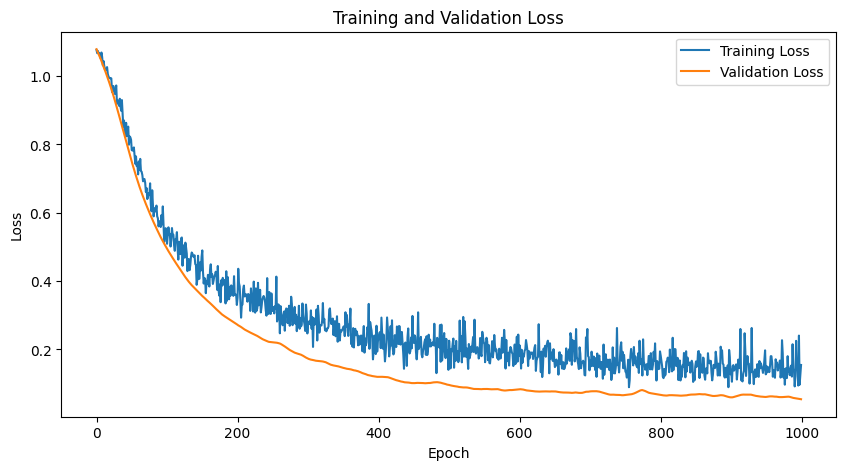

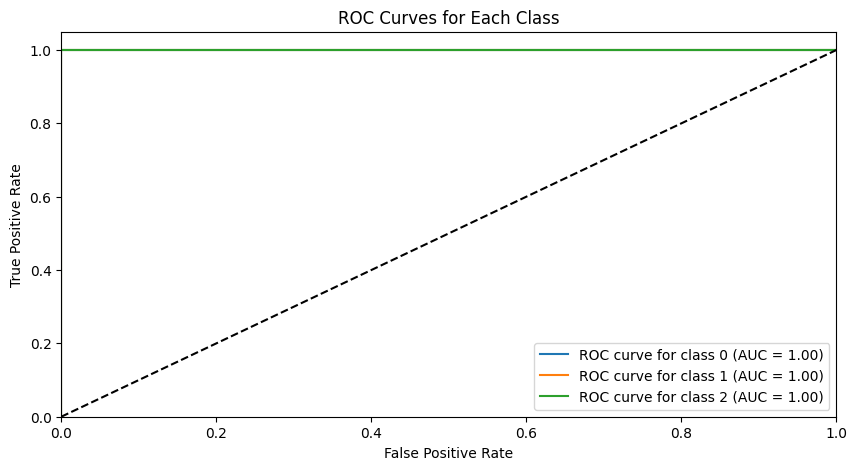

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import auc
training_losses = []
validation_losses = []
validation_accuracies = []


# Training loop with validation monitoring
num_epochs = 1000
for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, torch.argmax(y_train, dim=1))
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    # Validation phase
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test)
        loss_val = criterion(outputs_val, torch.argmax(y_test, dim=1))
        validation_losses.append(loss_val.item())

        # Calculate accuracy or other metrics on the validation set here
        predicted = torch.argmax(outputs_val, dim=1).numpy()
        actual = torch.argmax(y_test, dim=1).numpy()
        accuracy = accuracy_score(actual, predicted)
        validation_accuracies.append(accuracy)

    if ((epoch+1)%100 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {loss_val.item():.4f}, Validation Accuracy: {accuracy:.4f}')


# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs_test = model(X_test)
    predicted_test = torch.argmax(outputs_test, dim=1).numpy()
    actual_test = torch.argmax(y_test, dim=1).numpy()

    # Calculate accuracy
    accuracy_test = accuracy_score(actual_test, predicted_test)
    print(f"Test Accuracy: {accuracy_test:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(actual_test, predicted_test)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(actual_test, predicted_test, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


    # ROC-AUC curve for multiclass
    try:
      auc_roc = roc_auc_score(y_test, outputs_test, multi_class='ovr')
      print(f"ROC-AUC Score (One-vs-Rest): {auc_roc:.4f}")
    except ValueError:
      print("ROC-AUC score cannot be calculated for this data.")


    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    try:
      for i in range(num_classes):
          fpr[i], tpr[i], _ = roc_curve(y_test[:, i], outputs_test[:, i])
          roc_auc[i] = auc(fpr[i], tpr[i])


      plt.figure(figsize=(10, 5))
      for i in range(num_classes):
          plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')

      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curves for Each Class')
      plt.legend(loc="lower right")
      plt.show()
    except Exception as e:
      print(f"An error occured while trying to plot the ROC curves: {e}")

